# A sensitivity analysis of an alumina force field

## Theory
This section is based on _Global Sensitivity Analysis: The Primer, chapter 3_ by _A. Saltelli, M. Ratto, T. Andres, F. Campolongo, J. Cariboni, D. Gatelli, M. Saisana and S. Tarantola_.

#### Estimated Effects Method
This (qualitative) sensitivity method is useful when the amount of unput factors is too large to use computationally expensive variance-based techniques. It attempts to overcome the limitations of derivative-based approaches.

The method divides factors in different categories: negligible, linear/additive and nonlinear/interactions.

In general, one first defines a value $p$

## Technical
### Setting up the environment
The functionality is included in `glompo`, a python package that Michael Gustavo wrote.
First we need some tweaks to set the right path for the AMSPython interpreter as this 
seems to have some issues with jupyter.

For this to work, we require 3 components from glompo
* ReaxFFError - A wrapper that defines ReaxFF as an input function for sensitivity analysis

* Estimated Effects - The sensitivity analysis tool that is used in this case

* unstable trajectory - A sampler that samples points in the dimensionality of our problem +1 (since we have 69 parameters, this will be 70 in our case.). If the sample point does not find a valid entry, it will research for a point that does return a valid value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import dill
import pickle as pkl

import glompo
from glompo.interfaces.params import ReaxFFError
from glompo.analysis.estimatedeffects import EstimatedEffects
from glompo.analysis.trajectories import unstable_func_radial_trajectory_set

In [14]:
path = '/work/dumortil/Documents/projects/zeolytes/ff1_version3/sensitivity_analysis_glompo'

In [2]:
sys.path

['',
 '/work/dumortil/ams2021.207.r99676/bin/python3.6/lib/python36.zip',
 '/work/dumortil/ams2021.207.r99676/bin/python3.6/lib/python3.6',
 '/work/dumortil/ams2021.207.r99676/bin/python3.6/lib/python3.6/lib-dynload',
 '/work/dumortil/.scm/python/AMS2021.2.venv/lib/python3.6/site-packages',
 '/work/dumortil/ams2021.207.r99676/bin/python3.6/lib/python3.6/site-packages',
 '/work/dumortil/ams2021.207.r99676/scripting',
 '/work/dumortil/.scm/python/AMS2021.2.venv/lib/python3.6/site-packages/IPython/extensions',
 '/work/dumortil/.ipython']

In [3]:
# assert your dill version is 0.3.0 or above. If not, we will not be able to read in the results
dill.__version__

'0.3.4'

### Read in the results and building the EstimatedEffects object
The calculations have been performed on the IFP-cluster and are then serialized through `dill`, comparable with the `pickle` module.
These can be read in on the local machine, such that the exact state of the cluster can be reproduced.
The `EsitmatedEffects` object requires the input (parameters) and output dimensions (errors, thus one), the convergence threshold and the cut_off threshold as well as the trajectory style, which is 'radial' in the case of ReaxFF.

In [5]:
v = ReaxFFError.from_params_files('/work/dumortil/Documents/projects/zeolytes/ff1_version3/sensitivity_analysis_glompo')

In [6]:
n_parms = 69 #activated parameters

In [9]:
f_traj_40 = os.path.join('/work/dumortil/Documents/projects/zeolytes/ff1_version3/sensitivity_analysis_glompo', 'trajectory_40.dill')

In [10]:
with open(f_traj_40, 'rb') as f:
    traj = dill.load(f)

In [11]:
traj[-1]

1.0

In [12]:
ee = EstimatedEffects(input_dims=69,
                      output_dims=1,
                      groupings=None,
                      convergence_threshold=0,
                      cutoff_threshold=0.1,
                      trajectory_style='radial')
ee.add_trajectory(traj[0], traj[1])

### Plot all the possible information
Once the calculations are done, we can plot the results. 
* `ee.plot_rankings()` will rank the significance of the factors. The numerical results can be accessed through `ee.order_factors()` or `ee.rankings()`. The former is an array with the most significant parameter first, then the scond most significant, _etc._ . The former shows the rank of each corresponding parameter in the original parameter array.
* `ee.plot_sensitivities()` shows how the parameters are dependent from each and how they influence the results (linear, monotomic, interacting, ...)
* `ee.plot_convergence()` shows the convergence of the different runs (i.e. `r`). It shows the average switch in positions for all parameters. Ideally, this is 0 as this means that the parameters do not switch in the significance rankings in between the different runs.
* `ee.plot_bootstrap_metrics()` shows boxplots of $\mu$, $\mu^*$ and $\sigma$


In [15]:
ee.plot_rankings(path+'/plots/rankings')
ee.plot_sensitivities(path+'/plots/sensitivities')
ee.plot_convergence(path+'/plots/convergence')
ee.plot_bootstrap_metrics(path+'/plots/bootstrap')

In [72]:
ee.ranking()

array([15, 10, 33, 49, 22,  9, 50, 57, 34,  5, 16, 13, 59, 51, 62, 63, 64, 47, 14, 44, 66, 67, 68,  8, 35, 52, 61, 20,
       43, 65, 60, 11,  7, 21, 29, 56, 55, 28, 30, 69, 54, 19, 12,  4,  3,  2,  1, 58, 53, 38, 39, 42, 46, 25, 41, 27,
       36, 18,  6, 17, 24, 37, 48, 23, 26, 31, 40, 45, 32])

### Read in the results numerically

In [12]:
np.savetxt('ranking_param.csv', ee.ranking())

In [13]:
np.savetxt('order_factors_param.csv', ee.order_factors())

### Translate the parameters from ee to a params object

In [73]:
# ordered factors to a list. First is the most important factor, subsequently followed...
absolute_params = v.convert_indices_rel2abs(ee.order_factors())
most_important_20 = absolute_params[:20]

In [75]:
ee.order_factors()

array([46, 45, 44, 43,  9, 58, 32, 23,  5,  1, 31, 42, 11, 18,  0, 10, 59, 57, 41, 27, 33,  4, 63, 60, 53, 64, 55, 37,
       34, 38, 65, 68,  2,  8, 24, 56, 61, 49, 50, 66, 54, 51, 28, 19, 67, 52, 17, 62,  3,  6, 13, 25, 48, 40, 36, 35,
        7, 47, 12, 30, 26, 14, 15, 16, 29, 20, 21, 22, 39])

In [76]:
ee.ranking()

array([15, 10, 33, 49, 22,  9, 50, 57, 34,  5, 16, 13, 59, 51, 62, 63, 64, 47, 14, 44, 66, 67, 68,  8, 35, 52, 61, 20,
       43, 65, 60, 11,  7, 21, 29, 56, 55, 28, 30, 69, 54, 19, 12,  4,  3,  2,  1, 58, 53, 38, 39, 42, 46, 25, 41, 27,
       36, 18,  6, 17, 24, 37, 48, 23, 26, 31, 40, 45, 32])

In [92]:
# Get the params object
with open(os.path.join(path, 'reax_params.pkl'), 'rb') as f:
    parameters = pkl.load(f)

In [93]:
# Now we can activate only the most significant parameters

# deactivate everything
for param in parameters:
    param.is_active = False

# Activate the 20 most important ones
for param in absolute_params[:20]:
    parameters[param].is_active = True

In [94]:
# Assure only 20 parameters are active
len(parameters.active)

20

In [105]:
for i, x in enumerate(absolute_params):
    name = parameters[x].name
    newname=name.replace('_')
    print(r'{} & {} & {} \\'.format(i,x, parameters[x].name))

0 & 1788 & Al.O:r_0^sigma;;2;;Sigma bond length \\
1 & 1787 & Al.O:alpha_ij;;23a;;VdW parameter \\
2 & 1786 & Al.O:r_vdW;;23a;;VdW radius \\
3 & 1785 & Al.O:D_ij;;23a;;VdW energy \\
4 & 128 & O:p_val3;;13b,13a;;Valence angle parameter \\
5 & 2636 & Al.O.Al:p_val4;;13b;;Valence angle parameter \\
6 & 1428 & Al.O:p_bo2;;2;;Sigma bond order \\
7 & 1415 & Al.O:D_e^sigma;;6,11a;;Sigma-bond dissociation energy \\
8 & 123 & O:p_boc3;;4e,f;;Bond order correction \\
9 & 109 & O:r_0^pi;;2;;Pi bond covalent radius \\
10 & 1427 & Al.O:p_bo1;;2;;Sigma bond order \\
11 & 1556 & Al.Al:p_bo2;;2;;Sigma bond order \\
12 & 423 & Al:r_0^sigma;;2;;Sigma bond covalent radius \\
13 & 448 & Al:p_val3;;13b,13a;;Valence angle parameter \\
14 & 103 & O:r_0^sigma;;2;;Sigma bond covalent radius \\
15 & 131 & O:p_val5;;13b;;Valence angle parameter \\
16 & 2651 & O.Al.O:Theta_0,0;;13g;;180o-(equilibrium angle) \\
17 & 2634 & Al.O.Al:p_val7;;13c;;Undercoordination \\
18 & 1555 & Al.Al:p_bo1;;2;;Sigma bond order \\
19

In [24]:
# Store the updated parameters file again
with open(os.path.join(path, 'reax_params.pkl'), 'wb') as f:
    pkl.dump(parameters, f)

In [26]:
f_traj_1000iter = os.path.join(path, 'trajectory_40_1000iter.dill')

with open(f_traj_1000iter, 'rb') as f:
    f1000iter = dill.load(f)

In [36]:
ee.mu_star

array([3.36433627e+07, 5.34492797e+07, 1.33008124e+07, 3.94399213e+05, 2.37349047e+07, 5.57376431e+07, 4.91220124e+04,
       0.00000000e+00, 1.26564510e+07, 7.88751859e+07, 3.27265354e+07, 3.99559975e+07, 0.00000000e+00, 1.53783984e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.84143121e+05, 3.93647138e+07, 2.20127000e+06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.23238919e+07, 1.16296782e+07, 0.00000000e+00, 0.00000000e+00, 2.83028554e+07,
       2.46590943e+06, 0.00000000e+00, 0.00000000e+00, 4.63165333e+07, 6.27367172e+07, 2.55600098e+07, 1.72732162e+07,
       0.00000000e+00, 0.00000000e+00, 1.84348220e+07, 1.64437339e+07, 0.00000000e+00, 0.00000000e+00, 2.94761338e+07,
       4.51232769e+07, 8.49769263e+07, 1.18809846e+08, 1.58801641e+08, 4.40394408e+08, 0.00000000e+00, 0.00000000e+00,
       8.20422611e+06, 6.92703883e+06, 3.92401344e+06, 6.20075929e+05, 2.07598861e+07, 5.70039016e+06, 1.86019795e+07,
       1.14978418e+07, 3.12666318e+07, 6.5464033

In [38]:
ee.order_factors()

array([46, 45, 44, 43,  9, 58, 32, 23,  5,  1, 31, 42, 11, 18,  0, 10, 59, 57, 41, 27, 33,  4, 63, 60, 53, 64, 55, 37,
       34, 38, 65, 68,  2,  8, 24, 56, 61, 49, 50, 66, 54, 51, 28, 19, 67, 52, 17, 62,  3,  6, 13, 25, 48, 40, 36, 35,
        7, 47, 12, 30, 26, 14, 15, 16, 29, 20, 21, 22, 39])

## Generate the plot

In [84]:
data = ee.mu_star
data.sort()

labels = np.flip(absolute_params)

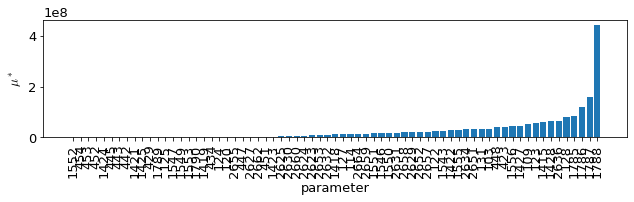

In [88]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(figsize=(9,3))
x = np.arange(len(data))
ax.bar(x=x, height=data)
ax.set_ylabel('$\mu^*$')
ax.set_xlabel('parameter')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.tight_layout()
fig.savefig('ranking.png', dpi=300)

In [89]:
labels

array([1552,  454,  453,  452, 1424,  445,  443,  442, 1421, 1425,  429, 1789,  125, 1547, 1549, 1553, 1790, 1419,
        434,  124,  120, 2655,  447, 2627, 2662,  451, 1423, 2625, 2630, 2660, 2624, 2623, 2653, 2632, 1418,  127,
        114, 2664, 2659, 1551, 1546, 1550, 2631, 2658, 2629, 2652, 2657,  122, 1543, 1422, 1555, 2634, 2651,  131,
        103,  448,  423, 1556, 1427,  109,  123, 1415, 1428, 2636,  128, 1785, 1786, 1787, 1788])